In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import Counter, defaultdict
import itertools
from gensim import utils
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# CBOW (Continuous Bag of Words) Word2Vec Implementation

CBOW predicts a target word from its surrounding context words within a window.
Unlike bigrams, CBOW considers multiple context words simultaneously to predict the center word.

## Key Differences from Bigrams:
- **Bigrams**: Uses pairs of adjacent words (word1 -> word2)
- **CBOW**: Uses multiple context words to predict center word ([context1, context2, ...] -> target)
- **Better Context**: CBOW captures richer semantic relationships

In [13]:
class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOWModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
        
    def forward(self, context_words):
        # context_words shape: (batch_size, context_size)
        embeds = self.embeddings(context_words)  # (batch_size, context_size, embedding_dim)
        # Average the context word embeddings
        context_vector = torch.mean(embeds, dim=1)  # (batch_size, embedding_dim)
        output = self.linear(context_vector)  # (batch_size, vocab_size)
        return output

In [14]:
class CustomLineSentence:
    def __init__(self, source, max_words_in_batch=100):
        self.source = source
        self.max_words_in_batch = max_words_in_batch

    def __iter__(self):
        """Iterate through the lines in the source."""
        with utils.open(self.source, 'rb') as fin:
            for line in itertools.islice(fin, None):
                line = utils.to_unicode(line).split()
                # Convert all tokens to lowercase
                line = [word.lower() for word in line]
                i = 0
                while i < len(line):
                    yield line[i: i + self.max_words_in_batch]
                    i += self.max_words_in_batch

In [28]:
class CBOWWord2Vec:
    def __init__(self, documents=None, vector_size=100, window=2, min_count=5, epochs=500, batch_size=256, learning_rate=0.001):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.wv = {}
        self.index_to_key = []
        
        if documents is not None:
            self.build_vocab(documents)
            self.train_model()
    
    def build_vocab(self, documents):
        """Build vocabulary and create CBOW training data"""
        # Flatten documents and count words
        all_words = [word for doc in documents for word in doc]
        word_counts = Counter(all_words)
        
        print(f"Total words before filtering: {len(all_words)}")
        print(f"Unique words before filtering: {len(word_counts)}")
        
        # Filter by min_count
        filtered_words = [word for word, count in word_counts.items() if count >= self.min_count]
        self.index_to_key = sorted(filtered_words)
        self.word_to_idx = {word: i for i, word in enumerate(self.index_to_key)}
        self.vocab_size = len(self.index_to_key)
        
        print(f"Vocabulary size after filtering: {self.vocab_size}")
        
        # Create CBOW training pairs
        self.context_target_pairs = []
        
        for doc in documents:
            filtered_doc = [word for word in doc if word in self.word_to_idx]
            
            for i in range(len(filtered_doc)):
                target_word = filtered_doc[i]
                
                # Get context words within the window
                context_words = []
                for j in range(max(0, i - self.window), min(len(filtered_doc), i + self.window + 1)):
                    if i != j:  # Skip the target word itself
                        context_words.append(filtered_doc[j])
                
                # Only add if we have context words
                if len(context_words) > 0:
                    self.context_target_pairs.append((context_words, target_word))
        
        print(f"Created {len(self.context_target_pairs)} context-target pairs for training")
        
        # Show some examples
        print("\nSample context-target pairs:")
        for i, (context, target) in enumerate(self.context_target_pairs[:5]):
            print(f"  {i+1}. Context: {context} -> Target: {target}")

    def prepare_training_data(self):
        """Convert context-target pairs to tensors"""
        contexts = []
        targets = []
        
        for context_words, target_word in self.context_target_pairs:
            # Convert context words to indices
            context_indices = [self.word_to_idx[word] for word in context_words]
            target_index = self.word_to_idx[target_word]
            
            # Pad or truncate context to fixed size (2 * window)
            max_context_size = 2 * self.window
            if len(context_indices) > max_context_size:
                context_indices = context_indices[:max_context_size]
            else:
                # Pad with zeros (we'll handle this in the model)
                context_indices.extend([0] * (max_context_size - len(context_indices)))
            
            contexts.append(context_indices)
            targets.append(target_index)
        
        return torch.tensor(contexts, dtype=torch.long), torch.tensor(targets, dtype=torch.long)

    def train_model(self):
        """Train the CBOW model"""
        # Prepare training data
        context_tensor, target_tensor = self.prepare_training_data()
        
        # Initialize model
        self.model = CBOWModel(self.vocab_size, self.vector_size)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
        print(f"\nStarting training for {self.epochs} epochs...")
        
        for epoch in range(self.epochs):
            # Shuffle data
            permutation = torch.randperm(context_tensor.size(0))
            epoch_loss = 0.0
            
            for i in range(0, context_tensor.size(0), self.batch_size):
                indices = permutation[i:i+self.batch_size]
                batch_contexts = context_tensor[indices]
                batch_targets = target_tensor[indices]
                
                optimizer.zero_grad()
                outputs = self.model(batch_contexts)
                loss = criterion(outputs, batch_targets)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
            
            if (epoch + 1) % 100 == 0:
                avg_loss = epoch_loss / (context_tensor.size(0) // self.batch_size + 1)
                print(f"Epoch {epoch + 1}/{self.epochs}, Average Loss: {avg_loss:.4f}")
        
        # Extract word embeddings
        self.extract_embeddings()
        print("Training completed!")

    def extract_embeddings(self):
        """Extract trained word embeddings"""
        with torch.no_grad():
            embeddings = self.model.embeddings.weight.data.numpy()
            for i, word in enumerate(self.index_to_key):
                self.wv[word] = embeddings[i]

    def most_similar(self, word, topn=10):
        """Find most similar words using cosine similarity"""
        if word not in self.wv:
            return f"Word '{word}' not in vocabulary"
        
        word_vec = self.wv[word]
        similarities = []
        
        for other_word, other_vec in self.wv.items():
            if other_word != word:
                # Cosine similarity
                similarity = np.dot(word_vec, other_vec) / (np.linalg.norm(word_vec) * np.linalg.norm(other_vec))
                similarities.append((other_word, similarity))
        
        # Sort by similarity and return top n
        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:topn]

    def save(self, path):
        """Save model to disk"""
        data = {
            'wv': self.wv,
            'index_to_key': self.index_to_key,
            'vector_size': self.vector_size,
            'window': self.window,
            'min_count': self.min_count,
        }
        torch.save(data, path)
    
    @classmethod
    def load(cls, path):
        """Load model from disk"""
        data = torch.load(path)
        model = cls()
        model.wv = data['wv']
        model.index_to_key = data['index_to_key']
        model.vector_size = data['vector_size']
        model.window = data['window']
        model.min_count = data['min_count']
        return model

## Load Data and Train CBOW Model

In [29]:
# Load data
MAX_WORDS_IN_BATCH = 100
sentences = CustomLineSentence('data/Royal_data.txt', max_words_in_batch=MAX_WORDS_IN_BATCH)
sentences = list(sentences)[:100]  # Limit for faster training

print(f"Number of sentences: {len(sentences)}")
print(f"Sample sentence: {sentences[0]}")

Number of sentences: 15
Sample sentence: ['the', 'future', 'king', 'is', 'the', 'prince']


In [35]:
# Train CBOW Word2Vec model
cbow_model = CBOWWord2Vec(
    documents=sentences,
    vector_size=100,
    window=5,
    min_count=2,
    epochs=200,
    batch_size=64,
    learning_rate=0.001
)

print(f"\nModel trained with vocabulary size: {cbow_model.vocab_size}")

Total words before filtering: 80
Unique words before filtering: 26
Vocabulary size after filtering: 17
Created 71 context-target pairs for training

Sample context-target pairs:
  1. Context: ['king', 'is', 'the', 'prince'] -> Target: the
  2. Context: ['the', 'is', 'the', 'prince'] -> Target: king
  3. Context: ['the', 'king', 'the', 'prince'] -> Target: is
  4. Context: ['the', 'king', 'is', 'prince'] -> Target: the
  5. Context: ['the', 'king', 'is', 'the'] -> Target: prince

Starting training for 200 epochs...
Epoch 100/200, Average Loss: 2.1816
Epoch 200/200, Average Loss: 2.1348
Training completed!

Model trained with vocabulary size: 17


## Test Word Similarity

In [ ]:
# Test word similarity
test_words = ['the', 'and', 'of', 'to', 'a']

for word in test_words:
    if word in cbow_model.wv:
        similar_words = cbow_model.most_similar(word, topn=5)
        print(f"\nWords most similar to '{word}':")
        for similar_word, similarity in similar_words:
            print(f"  {similar_word}: {similarity:.4f}")
    else:
        print(f"\nWord '{word}' not in vocabulary")


Words most similar to 'the':
  particular: 0.3236
  impossible: 0.2964
  market: 0.2933
  parliamentary: 0.2758
  communicate: 0.2693

Words most similar to 'and':
  rise: 0.2960
  important: 0.2907
  ability: 0.2904
  repudiated: 0.2858
  differing: 0.2845

Words most similar to 'of':
  worker: 0.3310
  using: 0.3294
  hans: 0.3223
  upon: 0.2693
  strongly: 0.2675

Words most similar to 'to':
  cause: 0.3111
  apart: 0.2680
  appeared: 0.2529
  intense: 0.2367
  postanarchism: 0.2367

Words most similar to 'a':
  anglophone: 0.3083
  deed: 0.2776
  periodical: 0.2555
  away: 0.2449
  currents: 0.2422


## Visualize Word Embeddings

Visualizing 30 words with shape: (30, 100)


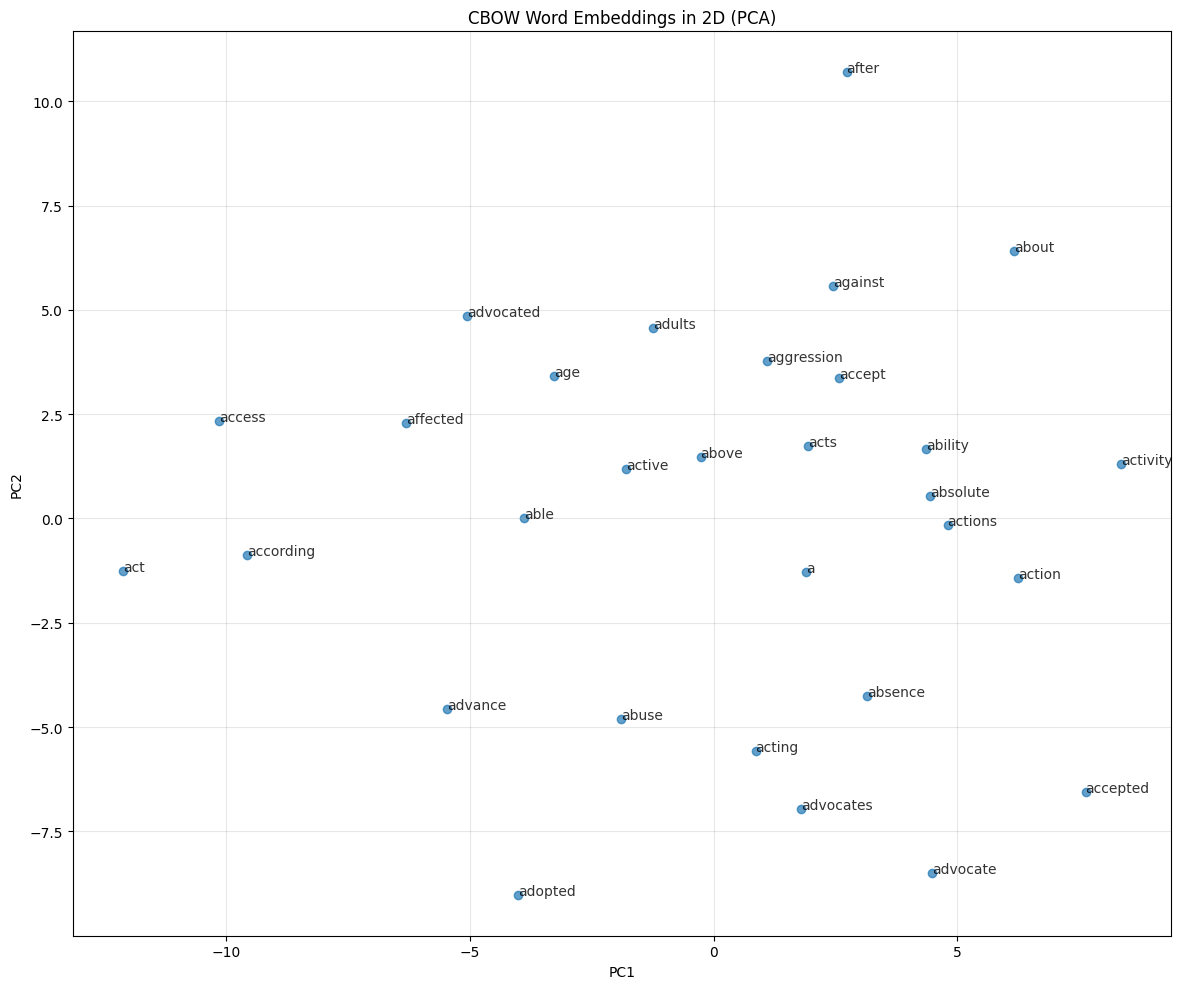

In [ ]:
# Visualize word embeddings using PCA
numOfWords = min(30, len(cbow_model.index_to_key))

# Extract word vectors from the model
words = cbow_model.index_to_key[:numOfWords]
word_vectors = [cbow_model.wv[word] for word in words]
weights = np.array(word_vectors)

print(f"Visualizing {numOfWords} words with shape: {weights.shape}")

# Reduce vectors to 2D using PCA
pca = PCA(n_components=2)
weights_2d = pca.fit_transform(weights)

# Plot the words in 2D
plt.figure(figsize=(12, 10))
plt.scatter(weights_2d[:, 0], weights_2d[:, 1], alpha=0.7)

# Annotate points with words
for i in range(numOfWords):
    plt.annotate(words[i], (weights_2d[i, 0], weights_2d[i, 1]), 
                fontsize=10, alpha=0.8)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('CBOW Word Embeddings in 2D (PCA)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

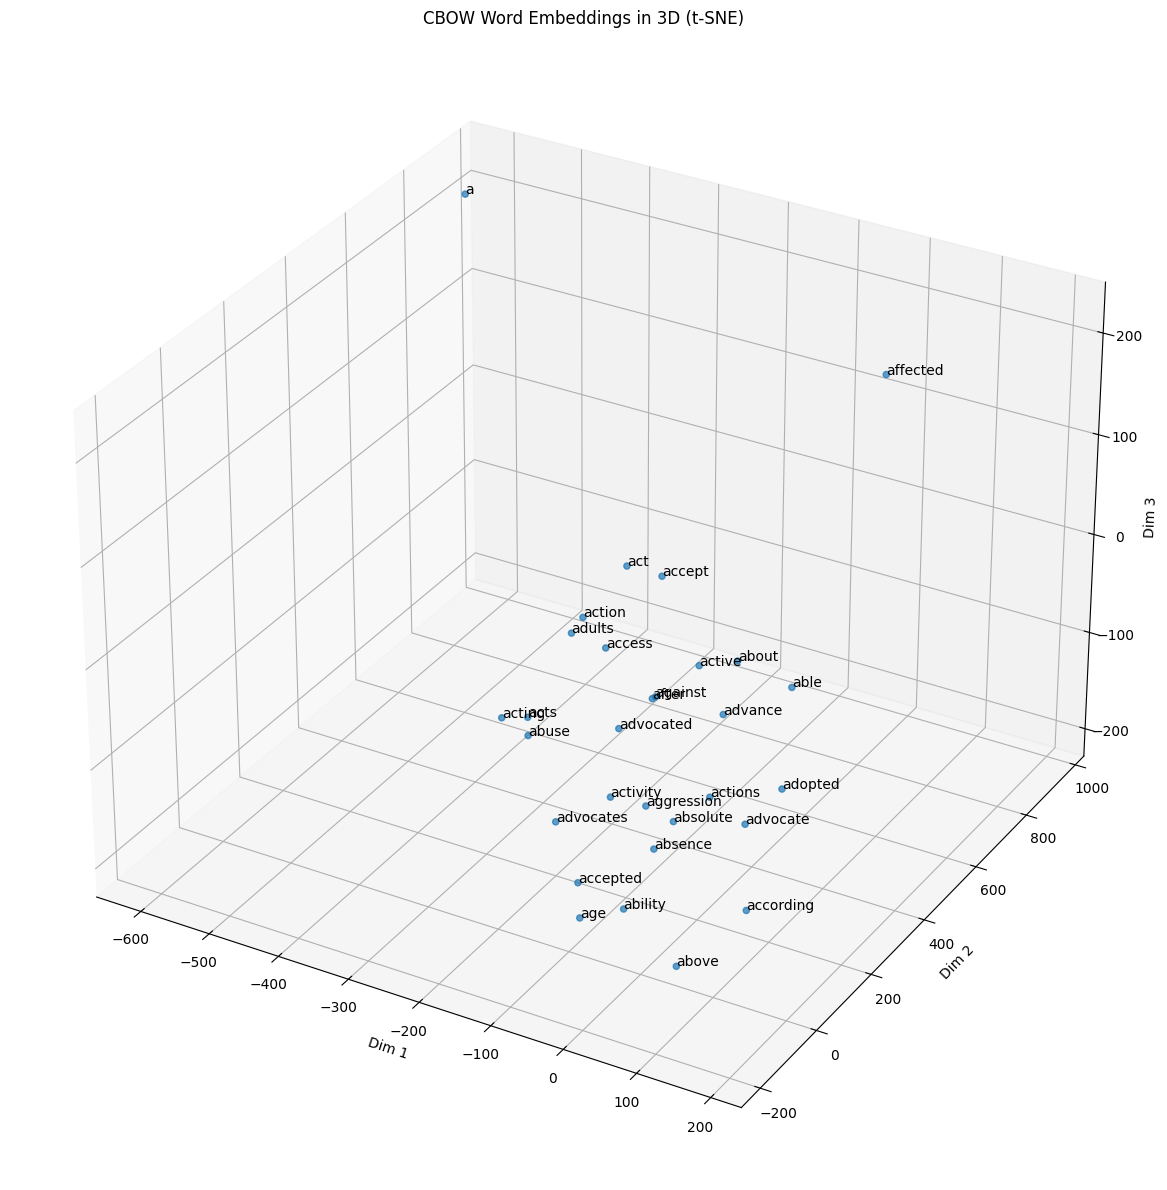

In [ ]:
# Visualize using t-SNE for better clustering
if numOfWords > 10:  # t-SNE needs sufficient data points
    from mpl_toolkits.mplot3d import Axes3D
    
    # Reduce vectors to 3D using t-SNE
    tsne = TSNE(n_components=3, random_state=42, perplexity=min(5, numOfWords//3))
    weights_3d = tsne.fit_transform(weights)
    
    # Plot the words in 3D
    fig = plt.figure(figsize=(14, 12))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(weights_3d[:, 0], weights_3d[:, 1], weights_3d[:, 2], alpha=0.7)
    
    # Annotate points with words
    for i in range(numOfWords):
        ax.text(weights_3d[i, 0], weights_3d[i, 1], weights_3d[i, 2], 
               words[i], fontsize=10)
    
    ax.set_xlabel('Dim 1')
    ax.set_ylabel('Dim 2')
    ax.set_zlabel('Dim 3')
    ax.set_title('CBOW Word Embeddings in 3D (t-SNE)')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough words for t-SNE visualization (need > 10)")

## Compare with Bigram Approach

### Key Differences:
1. **Context Window**: CBOW uses multiple words around target vs. bigram's single adjacent word
2. **Training Data**: CBOW creates context-target pairs vs. bigram's word pairs
3. **Architecture**: CBOW averages context embeddings vs. bigram's direct word-to-word mapping
4. **Semantic Quality**: CBOW typically produces better semantic representations

In [34]:
# Save the CBOW model
cbow_model.save('./models/cbow_word2vec.model')
print("CBOW model saved successfully!")

CBOW model saved successfully!


## Evaluation and Analysis

The CBOW model provides several advantages over the bigram approach:

1. **Richer Context**: Uses multiple surrounding words instead of just adjacent pairs
2. **Better Generalization**: Can capture semantic relationships across longer distances
3. **Continuous Representation**: Produces dense vectors that capture semantic similarity
4. **Efficient Training**: Predicts center word from context, leading to good word representations